In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
from imblearn.over_sampling  import SMOTE


def create_banner(title: str) -> (None):
    '''Accepts title(str) and displays a simple banner for the
    application using the provided title.
    '''
    print('')
    print('='*100)
    print(title)
    print('-'*100)
    
    return


def import_model_data(filename: str) -> (pd.DataFrame, 
                                         pd.DataFrame, 
                                         pd.Series):
    '''Accepts a csv file as input, reads it in as a pd.DataFrame, and
    divides the data into X, y. Returns X, y.'''
    
    print('\n[*] Importing model data...')
    model_data = pd.read_csv(filename)
    model_data = model_data.sample(500)

    print('\n[*] Identifying target...')
    X = model_data.drop('polarity', axis=1)
    y = model_data.polarity
    
    return model_data, X, y

  
def plot_my_conf_matrix(conf_matrix: np.ndarray, 
                        ax: plt.subplot) -> (None):
    '''Accepts an sklearn.metrics confusion matrix, and axis number
    and displays an sns.heatmap of the confusion matrix.
    '''
                        
    sns.heatmap(conf_matrix, annot=True, 
                fmt=".3f", linewidths=.5, 
                cmap='Blues_r', ax=ax)
                        
    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('Actual Label', fontsize=10)
    ax.set_title('Confusion Matrix',fontsize=12)
                        
    return
                        

def plot_my_roc_curve(clf: str, 
                      X_test: np.ndarray, 
                      y_test: np.ndarray, 
                      ax: plt.subplot) -> (None):
    '''Takes in a classifier, training data, and axis numbers. Displays
    an ROC Curve/AUC Score plot for the classifier.
    '''
                        
    metrics.plot_roc_curve(clf, X_test, y_test, alpha=1, lw=2, ax=ax)
    ax.set_title('ROC Curve/AUC Score',fontsize=12)
    
    return
    

def base_model(clf: str, 
               X_test: np.ndarray, y_test: np.ndarray, test_size: float, 
               random_state: float, smote: bool) -> (None):
    '''Accepts an sklearn classifier, data, and parameters and executes a 
    base model for each test size (0.2-0.4). Displays the classification 
    report, ROC-Curve and confusion matrix. 
    '''
    
    print('Test Size: ', test_size)
    print('[*] Generating basic model with TTS for:', clf, '...')
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                              test_size=test_size, random_state=random_state)
    
    if smote == True:
        print('[*] Oversampling data with SMOTE')
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print('[*] Generating Classification Report...')
    print('\nClassification Report')
    print('='*100)
    print(metrics.classification_report(y_test,y_pred))
    print('-'*100)

    create_banner('Confusion Matrix and ROC Plot')
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)    
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
    plot_my_conf_matrix(conf_matrix, ax1)
    plot_my_roc_curve(clf, X_test, y_test, ax2)
    plt.plot([0,1],[0,1], linestyle='--', lw=2, color='black')
    plt.show()
    print('')
    
    return
    

def run_cross_val_model(clf: str, 
                        X_test: np.ndarray, y_test: np.ndarray,
                        cv: sklearn.model_selection.StratifiedKFold) -> (None):
    '''Runs a cross validation model given a classifier, X, y data, and 
    cv parameters. Returns the model scores for each fold in the 
    cross validation.
    '''

    scores = pd.DataFrame()
    scores['Accuracy'] = model_selection.cross_val_score(clf, X, y, cv=cv,
                                                       scoring='accuracy')
    scores['AUC'] = model_selection.cross_val_score(clf, X, y, cv=cv, 
                                                    scoring='roc_auc')
    scores['Precision'] = model_selection.cross_val_score(clf, X, y, cv=cv, 
                                                       scoring='precision')
    scores['Recall'] = model_selection.cross_val_score(clf, X, y, cv=cv, 
                                                       scoring='recall')
    scores['F1'] = model_selection.cross_val_score(clf, X, y, cv=cv, 
                                                       scoring='f1')
    clf_scores = scores.sort_values(by='Precision').reset_index().drop('index', axis=1)
    clf_scores.loc['mean'] = scores.mean()
    
    display(clf_scores)
    
    return clf_scores, clf_scores.mean()


def plot_my_cross_val_roc_curve(clf: str, X: np.ndarray, y: np.ndarray,
                        cv: sklearn.model_selection.StratifiedKFold,
                        smote: bool) -> (None):
    '''Runs a cross validation model and returns a ROC curve with a plot for
    AUC results for each fold in the cross validation.
    ''' 
    fig = plt.figure(figsize=[8, 12])
    ax1 = fig.add_subplot(111, aspect='equal')
    
    true_pos_rates = []
    aucs = []
    mean_false_pos_rate = np.linspace(0, 1, 100)
    
    num = 1
    print('\n[*] Plotting ROC...')
    for train, test in cv.split(X, y):
        if smote == True:
            print('\n[*] Oversamping data with SMOTE...')
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_sample(X.iloc[train], y.iloc[train])            

        y_pred = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        false_pos_rate, true_pos_rate, t = metrics.roc_curve(y.iloc[test], y_pred[:, 1])
        true_pos_rates.append(np.interp(mean_false_pos_rate, 
                                        false_pos_rate, true_pos_rate))
        roc_auc = metrics.auc(false_pos_rate, true_pos_rate)
        aucs.append(roc_auc)
        plt.plot(false_pos_rate, true_pos_rate, lw=2, alpha=0.3, 
                 label='ROC fold %d (AUC = %0.2f)' % (num, roc_auc))
        num += 1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_true_pos_rate = np.mean(true_pos_rates, axis=0)
    mean_auc = metrics.auc(mean_false_pos_rate, mean_true_pos_rate)
    plt.plot(mean_false_pos_rate, mean_true_pos_rate, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return
    

def model_results(clfs: list, X_test: np.ndarray, y_test: np.ndarray,
          cv: sklearn.model_selection.StratifiedKFold) -> (pd.DataFrame):
    '''Creates a pd.DataFrame of model scores by executing an a classifer
    model on X, y using both train, test, split in various test sizes
    and cross validation. Plots a confusion matrix and ROC/AUC curve, and
    returns the model scores.
    '''
    model_scores = pd.DataFrame()
    num = 1
    for clf in clfs:
        test_sizes = [0.2, 0.3, 0.4]
        for test_size in test_sizes:
            create_banner('Basic Model without SMOTE')
            base_model(clf, X, y, test_size, 42, False)
            create_banner('Basic Model with SMOTE')
            base_model(clf, X, y, test_size, 42, True)
        
        create_banner('Cross Val Model')
        clf_scores, clf_scores_mean = run_cross_val_model(clf, X, y, cv)
        
        plot_my_cross_val_roc_curve(clf, X, y, cv, False)
        plot_my_cross_val_roc_curve(clf, X, y, cv, True)
        
    create_banner('Model Scores')
    print('\n[*] Calculating model scores...')
    model_scores = pd.concat([model_scores, clf_scores_mean], axis=0)
    display(model_scores)
            
    return model_scores

In [4]:
model_data, X, y = import_model_data('/Users/christineegan/AppleM1SentimentAnalysis/data/combined_data/model_data/2021_02_01_ModelData.csv')


[*] Importing model data...

[*] Identifying target...



Basic Model without SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.2
[*] Generating basic model with TTS for: GaussianNB() ...
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.35      0.96      0.51        23
         1.0       0.97      0.47      0.63        77

    accuracy                           0.58       100
   macro avg       0.66      0.71      0.57       100
weighted avg       0.83      0.58      0.60       100

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


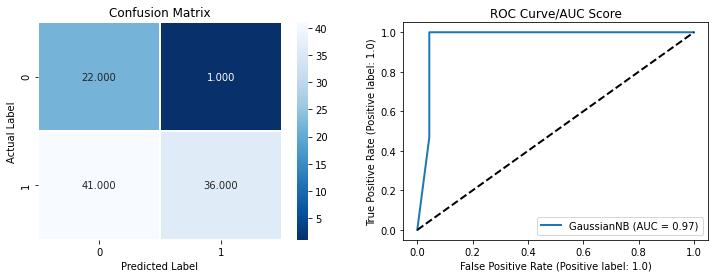



Basic Model with SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.2
[*] Generating basic model with TTS for: GaussianNB() ...
[*] Oversampling data with SMOTE
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.37      0.96      0.54        23
         1.0       0.98      0.52      0.68        77

    accuracy                           0.62       100
   macro avg       0.67      0.74      0.61       100
weighted avg       0.84      0.62      0.65       100

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


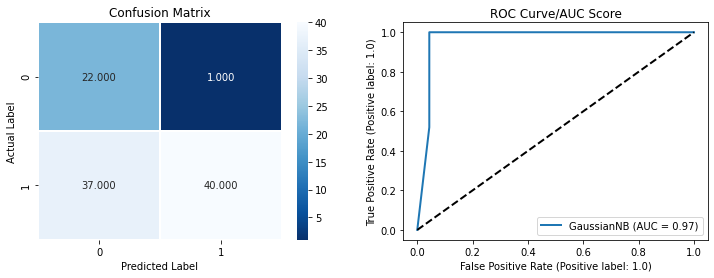



Basic Model without SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.3
[*] Generating basic model with TTS for: GaussianNB() ...
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.33      0.97      0.50        32
         1.0       0.98      0.47      0.64       118

    accuracy                           0.58       150
   macro avg       0.66      0.72      0.57       150
weighted avg       0.84      0.58      0.61       150

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


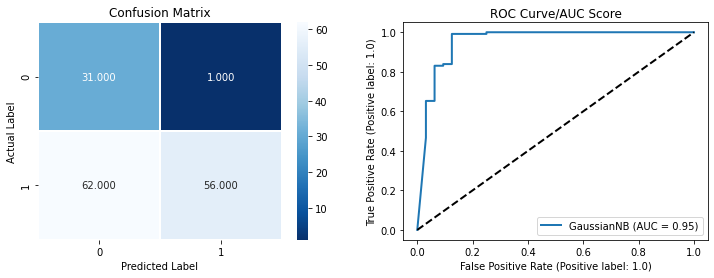



Basic Model with SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.3
[*] Generating basic model with TTS for: GaussianNB() ...
[*] Oversampling data with SMOTE
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.36      0.97      0.53        32
         1.0       0.98      0.53      0.69       118

    accuracy                           0.63       150
   macro avg       0.67      0.75      0.61       150
weighted avg       0.85      0.63      0.66       150

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


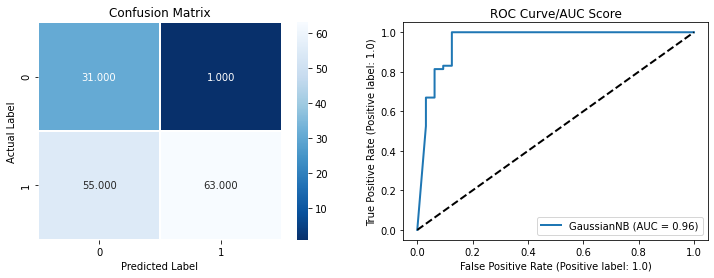



Basic Model without SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.4
[*] Generating basic model with TTS for: GaussianNB() ...
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.92      0.63        49
         1.0       0.96      0.68      0.80       151

    accuracy                           0.74       200
   macro avg       0.72      0.80      0.72       200
weighted avg       0.85      0.74      0.76       200

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


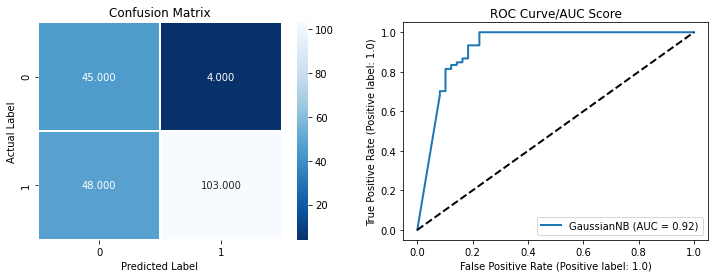



Basic Model with SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.4
[*] Generating basic model with TTS for: GaussianNB() ...
[*] Oversampling data with SMOTE
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.92      0.63        49
         1.0       0.96      0.68      0.80       151

    accuracy                           0.74       200
   macro avg       0.72      0.80      0.72       200
weighted avg       0.85      0.74      0.76       200

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


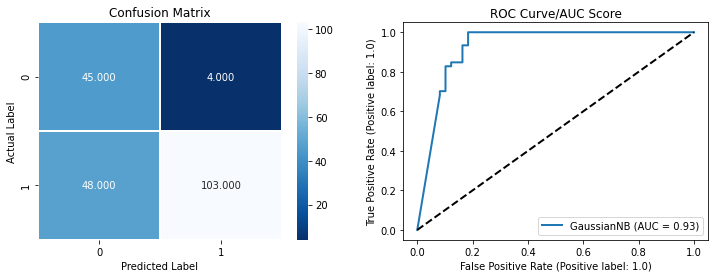



Cross Val Model
----------------------------------------------------------------------------------------------------


,Accuracy,AUC,Precision,Recall,F1
0,0.630,0.941558,0.976190,0.532468,0.689076
1,0.640,0.934218,0.976744,0.545455,0.700000
2,0.660,0.919819,0.977778,0.571429,0.721311
3,0.660,0.930548,1.000000,0.558442,0.716667
4,0.590,0.971203,1.000000,0.467532,0.637168
mean,0.636,0.939469,0.986142,0.535065,0.692844



[*] Plotting ROC...


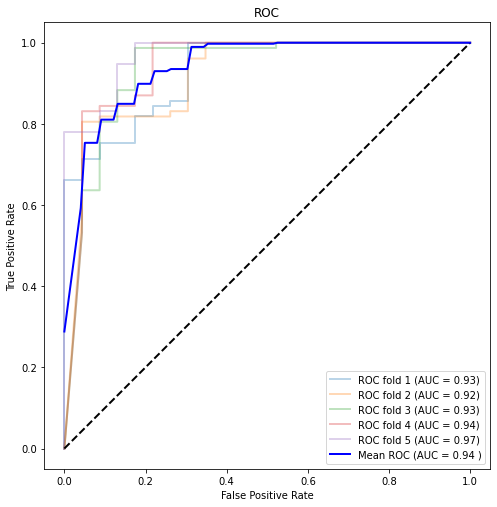


[*] Plotting ROC...

[*] Oversamping data with SMOTE...


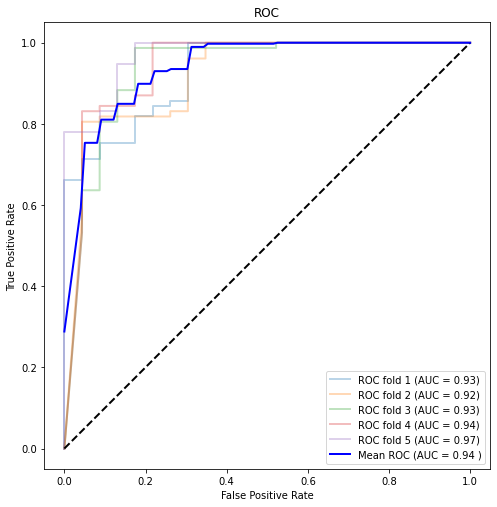


Basic Model without SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.2
[*] Generating basic model with TTS for: LogisticRegression(max_iter=1000) ...
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96        23
         1.0       0.99      0.99      0.99        77

    accuracy                           0.98       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.98      0.98      0.98       100

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


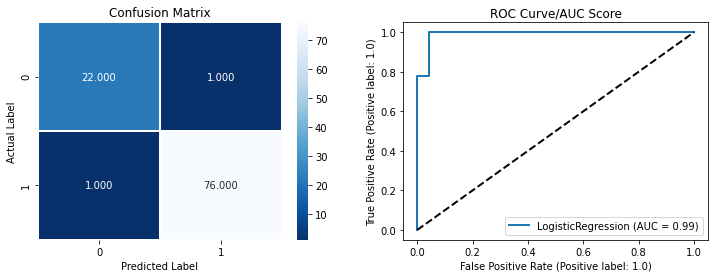



Basic Model with SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.2
[*] Generating basic model with TTS for: LogisticRegression(max_iter=1000) ...
[*] Oversampling data with SMOTE
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.76      0.96      0.85        23
         1.0       0.99      0.91      0.95        77

    accuracy                           0.92       100
   macro avg       0.87      0.93      0.90       100
weighted avg       0.93      0.92      0.92       100

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


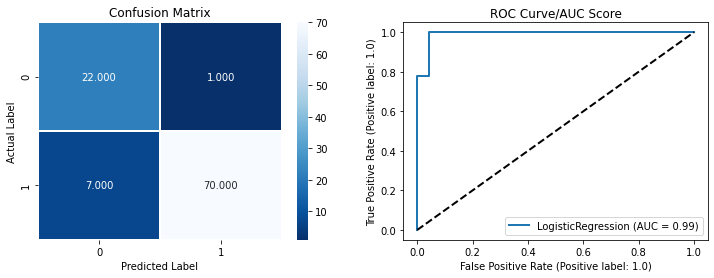



Basic Model without SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.3
[*] Generating basic model with TTS for: LogisticRegression(max_iter=1000) ...
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       1.00      0.94      0.97        32
         1.0       0.98      1.00      0.99       118

    accuracy                           0.99       150
   macro avg       0.99      0.97      0.98       150
weighted avg       0.99      0.99      0.99       150

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


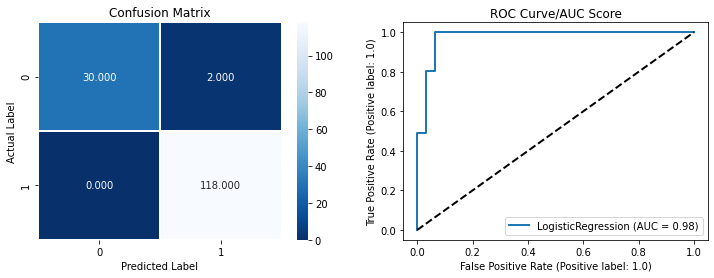



Basic Model with SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.3
[*] Generating basic model with TTS for: LogisticRegression(max_iter=1000) ...
[*] Oversampling data with SMOTE
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.77      0.94      0.85        32
         1.0       0.98      0.92      0.95       118

    accuracy                           0.93       150
   macro avg       0.88      0.93      0.90       150
weighted avg       0.94      0.93      0.93       150

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


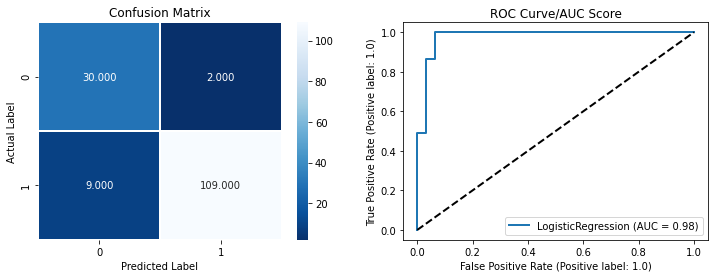



Basic Model without SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.4
[*] Generating basic model with TTS for: LogisticRegression(max_iter=1000) ...
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.96      0.90      0.93        49
         1.0       0.97      0.99      0.98       151

    accuracy                           0.96       200
   macro avg       0.96      0.94      0.95       200
weighted avg       0.96      0.96      0.96       200

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


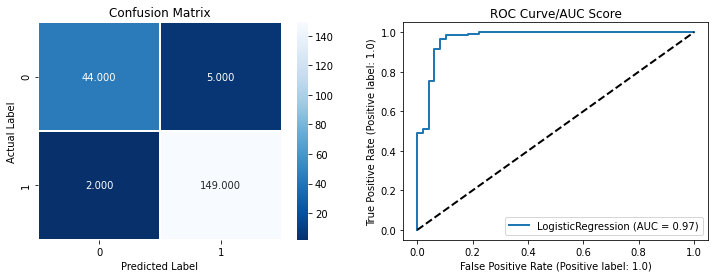



Basic Model with SMOTE
----------------------------------------------------------------------------------------------------
Test Size:  0.4
[*] Generating basic model with TTS for: LogisticRegression(max_iter=1000) ...
[*] Oversampling data with SMOTE
[*] Generating Classification Report...

Classification Report
              precision    recall  f1-score   support

        -1.0       0.90      0.94      0.92        49
         1.0       0.98      0.97      0.97       151

    accuracy                           0.96       200
   macro avg       0.94      0.95      0.95       200
weighted avg       0.96      0.96      0.96       200

----------------------------------------------------------------------------------------------------

Confusion Matrix and ROC Plot
----------------------------------------------------------------------------------------------------


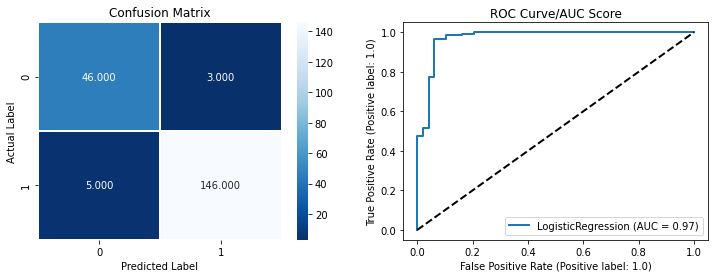



Cross Val Model
----------------------------------------------------------------------------------------------------


,Accuracy,AUC,Precision,Recall,F1
0,0.96,0.996612,0.962025,0.987013,0.974359
1,0.94,0.967250,0.973333,0.948052,0.960526
2,0.97,0.964992,0.974359,0.987013,0.980645
3,0.97,0.988142,0.974359,0.987013,0.980645
4,0.96,0.976849,0.986667,0.961039,0.973684
mean,0.96,0.978769,0.974149,0.974026,0.973972



[*] Plotting ROC...


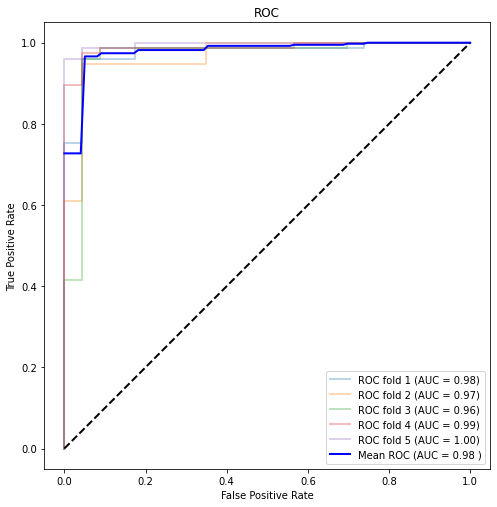


[*] Plotting ROC...

[*] Oversamping data with SMOTE...


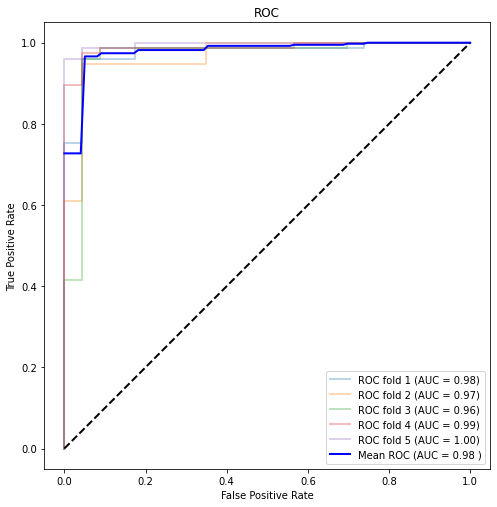


Model Scores
----------------------------------------------------------------------------------------------------

[*] Calculating model scores...


,0
Accuracy,0.960000
AUC,0.978769
Precision,0.974149
Recall,0.974026
F1,0.973972


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

clf1 = GaussianNB()
clf2 = LogisticRegression(max_iter=1000)

cv = sklearn.model_selection.StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

model_scores = model_results([clf1, clf2], X, y, cv)